In [1]:
from __future__ import division
from utils import *
from functions import *
from cycler import cycler
import matplotlib as mpl
# %matplotlib inline
from numba import autojit
%load_ext autoreload
%autoreload 2

today = datetime.date.today()
todayStr = '%04d%02d%02d' % (today.year, today.month, today.day)
# todayStr = '20151005'
DIRECTORY = os.path.expanduser("~/Dropbox/0000 - PhD/figures/"+todayStr+"/")
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)
    
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
'''
SINGLE NEURON FREQUENCY RESPONSE
'''
T = 2000
dt = 1
t = np.arange(0,T,dt)
F = np.logspace(0.5,2.3,200)

@autojit
def resonanceFS(F,tauv=15):
    res_var = np.empty(len(F), dtype=np.float64)
    b = 2
    for k,f in enumerate(F):
        A = 0.01
        I = A*np.cos(2*np.pi*f*t/1000)
        res_v = []
        res_u = []
        u=0
        t_rest=0
        
        # izh neuron model for cortical fast spiking neurons (that burst)
        v = -60
        for i in range(len(t)):
            v += dt/tauv * ( (v+60)*(v+50) - 20*u + 8*I[i])
            u += dt * 0.044 * ( (v +55) - u)
            if v>25:
                v = -40
                u += 50
            if i*dt>1500:
                res_v.append(v/A)
 
            
        var = np.var(res_v)
#         var = np.max(res_v)-np.min(res_v)
        res_var[k] = var
    return res_var

In [4]:
gpizh = resonanceFS(F)
taulist = np.arange(15,105,10)
modres = [resonanceFS(F,tauv=tauvi) for tauvi in taulist ]
colors = np.linspace(3368652,13382451, len(modres))
gpizh2 = resonanceFS(F, tauv=45)


fontsize=14

matplotlib.rc('xtick', labelsize=fontsize)
matplotlib.rc('ytick', labelsize=fontsize)
matplotlib.rc('axes', labelsize = fontsize)
matplotlib.rc('axes', titlesize = fontsize)
matplotlib.rc('lines', linewidth=2)
matplotlib.rc('axes', facecolor = "white")

In [ ]:
plt.figure(figsize=(6,4))
for i,mod in enumerate(modres):
    plt.semilogx(F, mod/np.nanmax(mod), label='%.1f'%(F[np.argmax(mod)]), color=colorsys.hsv_to_rgb(1, 0.5, 0.3 + i/len(modres)*0.7))

# plt.semilogx(F, gpizh2/np.nanmax(gpizh2), label='%.1f'%(F[np.argmax(gpizh2)]), color='#3366cc')
# plt.semilogx(F, gpizh/np.nanmax(gpizh), label='%.1f'%(F[np.argmax(gpizh)]), color="#cc3333")
# plt.semilogx(F, cc/np.max(cc), '--', label='Tchumatchenko 2014')
# plt.semilogx(F, izh/np.max(izh), '--', label='Izhikevich 2003')
# plt.plot(x,y/np.max(y), 'k-', markersize=10, label='Cardin 2009 FS PV-Cre')
# plt.plot(x,y/np.max(y), 'k.', markersize=10)
plt.ylim([0,1.05])
# plt.legend()
plt.xlabel('Stimulus Frequency [Hz]')
plt.ylabel('Normalised Response Amplitude')
plt.xlim([0,200])
plt.title('Subthreshold Resonant Property', y=1.08)
plt.legend()
plt.tight_layout()
plt.savefig(DIRECTORY+'_resonanceTRN.pdf')



In [6]:
# Instantiate classes
cortex = Cortex()
trn = TRN()
gr = GRAPH()

# styling
gammaColor = '#00cc99'

def plotCSD(i1,i2, start=0, end=40000, ax=None):
    f, Pxy = signal.csd(i1[start:end], i2[start:end], fs=1/0.00025, nperseg=1024)
    ax.plot(f, np.abs(Pxy))
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('CSD [V**2/Hz]')
    ax.set_xlim([0,300])
    ax.set_title('Cross-spectrum between LFPs of 2 networks')
    return ax



def xax(gamma, duration):
    x= np.arange(0,(duration-1)/1000,(duration)/1000/len(gamma) )
    return x

def plotWeights(tauv=15):
    spikes_x, spikes_y, spikes_x_tc, spikes_y_tc, \
                   gamma, correlation, ssp1, \
    stimulation, p, q, LowSp, vm,i1,i2 = cortex.readSimulation(N=N, r=r, i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, \
                                                            WII=WII, LTP=LTP, LTD=LTD, \
                                                            model=model, glob=glob, sG=sG, sWII=sWII, tauv=tauv, with_currents=True )
    
    titlestr = r'$N=%d$  $\frac{\alpha_{LTP}}{\alpha_{LTD}}=%d$  $g_0=%.1f$  $\nu=%d$ $sG=%d$ $sW_{II}=%d$ $LTD=%.6g$ $\tau_v=%d$'\
        %(N, ratio, G, sigma, sG, sWII, LTD, tauv)
    titlestr2 = 'N=%d  LTD/LTP=%d g0=%.1f  nu=%d  sG=%d sWII=%d' %(N, ratio, G, sigma, sG, sWII)

    
    GAP2D = cortex.readMatrix(N=N, r=r, i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, \
                                                            WII=WII, LTP=LTP, LTD=LTD,\
                          model=model, glob=glob, type="GAP",  sG=sG, sWII=sWII, tauv=tauv)
    GAP2D0 = cortex.readMatrix(N=N, r=r, i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, \
                                                                WII=WII, LTP=LTP, LTD=LTD, \
                               model=model, glob=glob, type="GAP0", sG=sG, sWII=sWII, tauv=tauv )
    WII2D = cortex.readMatrix(N=N, r=r, i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, \
                                                                WII=WII, LTP=LTP, LTD=LTD, \
                              model=model, glob=glob, type='WII', sG=sG, sWII=sWII, tauv=tauv )
    fig = plt.figure(figsize=(12,14))
    
    fontsize=10
    matplotlib.rc('xtick', labelsize=fontsize)
    matplotlib.rc('ytick', labelsize=fontsize)
    matplotlib.rc('axes', labelsize = fontsize)
    matplotlib.rc('axes', titlesize = fontsize)
    
    
    ax0 = fig.add_subplot(421)
    ax0.plot(xax(gamma,d1+d2+d3), gamma, color='c')
    
    
    ax01 = fig.add_subplot(422)
    T = 2000
    dt = 1
    t = np.arange(0,T,dt)
    F = np.logspace(0.5,2.3,200)
    mod = resonanceFS(F,tauv=tauv)
    mod15 = resonanceFS(F,tauv=15)
    ax01.semilogx(F, mod/np.nanmax(mod), label='%.1f'%(F[np.argmax(mod)]), color='c')
    ax01.semilogx(F, mod15/np.nanmax(mod15), label='%.1f'%(F[np.argmax(mod15)]), color='r')
    ax01.set_ylim([0,1.05])
    # plt.legend()
    ax01.set_xlabel('Stimulus Frequency [Hz]')
    ax01.set_ylabel('Normalised Response Amplitude')
    ax01.set_xlim([0,200])
    ax01.set_title('Subthreshold Resonant Property', y=1.08)
    ax01.legend()
    
    ax1 = plt.subplot(434)
    # plt.imshow(np.array(GAP2D)[100:150,1:20], interpolation='nearest')
    im1 = ax1.imshow(np.array(GAP2D0), interpolation='nearest')
    ax1.set_title(r'$\gamma(t = 0)$')
    fig.colorbar(im1)
    # plt.figure(figsize=(10,10))
    ax2 = plt.subplot(435)
    im2 = ax2.imshow(np.array(GAP2D), interpolation='nearest')
    ax2.set_title(r'$\gamma(t = END)$')
    fig.colorbar(im2)
    # plt.figure(figsize=(10,10))
    ax3 = plt.subplot(436)
    im3 = ax3.imshow(np.array(WII2D), interpolation='nearest')
    ax3.set_title(r'$W_{II}$')


    ax1=fig.add_subplot(425)
    ax2=fig.add_subplot(426)
    gr.plotRaster(spikes_x[:5000],spikes_y[:5000], ax=ax1)
    gr.plotRaster(spikes_x[-5000:],spikes_y[-5000:],ax=ax2)
    
    
    ax7 = fig.add_subplot(427)
    ax8 = fig.add_subplot(428)
    plotCSD(i1,i2, start=0, end=40000, ax=ax7)
    plotCSD(i1,i2, start=-40000, end=-1, ax=ax8)
    
    
    
    plt.suptitle(titlestr)

    plt.savefig(DIRECTORY + "full_sWII-%d_sG-%d_WII-%d_G-%d_N-%d_t-%d_LTD-%d_tauv-%d.pdf" %(sWII, sG, WII, G, N, d1+d2+d3, LTD>1e-8, tauv))
    del fig
    # gr.plotRasterGPU(spikes_x[:],spikes_y[:], "test_%s.html"%(str(G)), saveImg=0)
    return 0

In [7]:
# #-------------------------------
# # PARAMS SEARCH
# #-------------------------------
N = 100
G = 20
d1 = 10
d2 = 1000
d3 = 10
before = d1
after = d2+d3
sigma = 60
WII = 1400 #2800
LTP = 0.01
LTD = 0.002
S = 100
model = "gp-izh-subnetworks"
glob = 0

# shared weights
sG = 0
sWII = 0

FACT = 1
r=0
it = 8
binsize=1000
coeff=1
ratio = 15
LTD  = 1e-0*4.7e-6 * FACT * N
LTP = ratio * LTD
tauv=45

# for S in np.arange(50,400,50):
#     Parallel(n_jobs=8)(delayed(cortex.runSimulation)(N,0, G, S, d1, d2, d3, before, after, sigma, \
# WII, LTP, LTD) for G in np.linspace(1,9,"8))

# sWIIList = [0,1,5,10,-1]
# sGList = [0,1,5,10,-1]
# LTDList = [1e-9*4.7e-6 * FACT * N, 1e-0*4.7e-6 * FACT * N]
# taulist = np.arange(15,105,10)

sWIIList = [-1]
sGList = [0]
LTDList = [1e-9*4.7e-6 * FACT * N, 1e-0*4.7e-6 * FACT * N]
taulist = np.arange(15,105,10)

cortex.runSimulation(N=N,i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, before=before, after=after,\
                                 s=sigma, WII=WII, LTP=LTP, LTD=LTD, model=model, r=r, glob=glob, sG=sG, sWII=sWII, tauv=tauv)

plotWeights(tauv=tauv)

# for tauv in taulist:
#     for d2 in [5000,10000,20000,60000]:
#         for sWII in sWIIList:
#             for sG in sGList:
#                 for LTD in LTDList:
#                     LTP = ratio * LTD
#                     cortex.readSimulation(N=N, r=r, i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, \
#                                                             WII=WII, LTP=LTP, LTD=LTD, \
#                                                             model=model, glob=glob, sG=sG, sWII=sWII, tauv=tauv )
#                     plotWeights(tauv=tauv)



./cortex -N 100 -ext _0.txt -d1 10 -d2 1000 -d3 10 -before 10 -after 1010 -S 100 -G 20 -s 60 -WII 1400 -LTP 0.00705 -LTD 0.00047 -model gp-izh-subnetworks -r 0 -global 0 -sG 0 -sWII 0 -tauv 45


0

In [19]:
spikes_x, spikes_y, spikes_x_tc, spikes_y_tc, \
                   gamma, correlation, ssp1, \
    stimulation, p, q, LowSp, vm = cortex.readSimulation(N=N, r=r, i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, \
                                                            WII=WII, LTP=LTP, LTD=LTD, \
                                                            model=model, glob=glob, sG=sG, sWII=sWII, tauv=tauv )

titlestr = r'$N=%d$  $\frac{\alpha_{LTP}}{\alpha_{LTD}}=%d$  $g_0=%.1f$  $\nu=%d$ $sG=%d$ $sW_{II}=%d$ $LTD=%.6g$'\
%(N, ratio, G, sigma, sG, sWII, LTD)
titlestr2 = 'N=%d  LTD/LTP=%d g0=%.1f  nu=%d  sG=%d sWII=%d' %(N, ratio, G, sigma, sG, sWII)

# plt.plot(xax(gamma,d1+d2+d3), gamma, color='c')
# plt.title(titlestr)

In [6]:
# gr.plotRasterGPU(spikes_x[-50000:],spikes_y[-50000:], titlestr2)


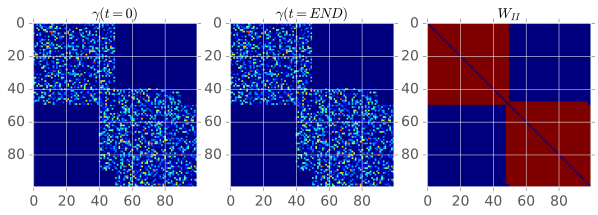

In [7]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(131)
# plt.imshow(np.array(GAP2D)[100:150,1:20], interpolation='nearest')
ax1.imshow(np.array(GAP2D), interpolation='nearest')
ax1.set_title(r'$\gamma(t = 0)$')
# plt.colorbar()
# plt.figure(figsize=(10,10))
ax2 = plt.subplot(132)
ax2.imshow(np.array(GAP2D0), interpolation='nearest')
ax2.set_title(r'$\gamma(t = END)$')
# plt.colorbar()
# plt.figure(figsize=(10,10))
ax3 = plt.subplot(133)
ax3.imshow(np.array(WII2D), interpolation='nearest')
ax3.set_title(r'$W_{II}$')
# plt.colorbar()

In [18]:
# plt.figure(figsize=(10,5))
# n,bins,patchs = plt.hist(spikes_x, bins=1000, color='c', facecolor='c', edgecolor='none')
# plt.title('LFP')

In [19]:
b=1

In [20]:
b

1